In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
if __name__ == "__main__":
    print("Hello LangGraph")

Hello LangGraph


In [3]:
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)

graph = MessageGraph()

graph.add_node("oracle", model)
graph.add_edge("oracle", END)

graph.set_entry_point("oracle")

runnable = graph.compile()

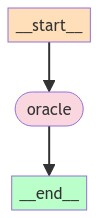

In [4]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
runnable.invoke(HumanMessage("What is 1 + 1?"))

[HumanMessage(content='What is 1 + 1?', id='f6f12def-ab3b-45cf-b9b4-1b9944576ed9'),
 AIMessage(content='1 + 1 equals 2.', response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-34d4c570-1a89-47f7-b75e-bd6c8a92a1f5-0', usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23})]

In [6]:
from typing import Literal

from langchain_core.tools import tool

from langgraph.graph import END, START
from langgraph.prebuilt import ToolNode


@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number


model = ChatOpenAI(temperature=0)
model_with_tools = model.bind_tools(tools=[multiply])

graph = MessageGraph()

graph.add_node("oracle", model_with_tools)

tool_node = ToolNode([multiply])
graph.add_node("multiply", tool_node)
graph.add_edge(START, "oracle")
graph.add_edge("multiply", END)


def router(state: list[BaseMessage]) -> Literal["multiply", "__end__"]:
    tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return END


graph.add_conditional_edges("oracle", router)
runnable = graph.compile()

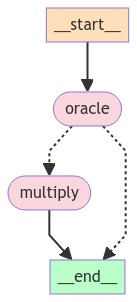

In [7]:
try:
    display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
runnable.invoke(HumanMessage("What is 123 * 456?"))

[HumanMessage(content='What is 123 * 456?', id='c9eab0f6-2c73-489c-8969-43821211e0a2'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xld9cRYlbrTUgwS08dYK6NxM', 'function': {'arguments': '{"first_number":123,"second_number":456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 57, 'total_tokens': 76}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4ee5e157-cc7a-4bc9-bdd2-84cf26bea834-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': 'call_Xld9cRYlbrTUgwS08dYK6NxM'}], usage_metadata={'input_tokens': 57, 'output_tokens': 19, 'total_tokens': 76}),
 ToolMessage(content='56088', name='multiply', id='3cd8de27-c819-424a-9ae0-fc0aee123b46', tool_call_id='call_Xld9cRYlbrTUgwS08dYK6NxM')]

In [9]:
runnable.invoke(HumanMessage("What is your name?"))

[HumanMessage(content='What is your name?', id='29b9de60-0e9d-4785-9289-c8f6f1a4ce90'),
 AIMessage(content='My name is Assistant. How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 54, 'total_tokens': 67}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e0b19ecd-94bd-469a-abe9-1c0011c7eb3d-0', usage_metadata={'input_tokens': 54, 'output_tokens': 13, 'total_tokens': 67})]